In [28]:
import numpy as np
import sys
import json

from tqdm.auto import tqdm
from rdkit import Chem
import torch
from matplotlib import pyplot as plt

sys.path.append("../")
from config import ROOT_DIR
from Source.models.GCNN_FCNN.model import GCNN_FCNN
from Source.models.GCNN_FCNN.old_featurizer import ConvMolFeaturizer
from Source.trainer import ModelShell

In [29]:
with open(ROOT_DIR / "Source/models/GCNN_FCNN/skipatom_vectors_dim200.json", "r") as f:
    get_vector = json.load(f)
get_vector["mean"] = np.array(list(get_vector.values())).mean(axis=0).tolist()
get_vector["zero"] = np.zeros((200,)).tolist()

def get_features(metals):
    return np.array([get_vector[metal] for metal in metals])

In [30]:
Ln_metals = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', ]
An_metals = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

other_metals = ['Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Mo', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs', 'Ba', 'Hf', 'Re',
                'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi']

In [31]:
metals = list(set(["Y", "Sc"] + Ln_metals + An_metals) - {"Ac", "Pa"})
metals = np.array(metals)[np.array([Chem.Atom(metal).GetAtomicNum() for metal in metals]).argsort()]

In [38]:
# final_5fold_regression_2023_06_10_07_58_17
train_folder = ROOT_DIR / "Output/WithCondAdd/5fold/Bk_5fold_regression_2023_06_01_05_15_06"

super_model = ModelShell(GCNN_FCNN, train_folder)

In [39]:
def get_graph(smiles, metal, charge=3, temperature=25, ionic_str=0.1):
    mol_featurizer = ConvMolFeaturizer()
    graph = mol_featurizer.featurize(Chem.MolFromSmiles(smiles))
    conditions = torch.tensor([[charge, temperature, ionic_str]])
    graph.metal_x = torch.cat((torch.tensor([get_vector[metal]]), conditions), dim=-1)
    return graph

In [40]:
def predict(smiles, metal):
    graph = get_graph(smiles, metal)
    return super_model(graph)["logK"].item()

In [41]:
ind = range(len(metals))
pred = [predict("OC(CN(CC(O)=O)CCN(CC(O)=O)CC(O)=O)=O", metal) for metal in metals]
true = [get_logK("OC(CN(CC(O)=O)CCN(CC(O)=O)CC(O)=O)=O", metal) for metal in metals]
mean_pred = predict("OC(CN(CC(O)=O)CCN(CC(O)=O)CC(O)=O)=O", "mean")

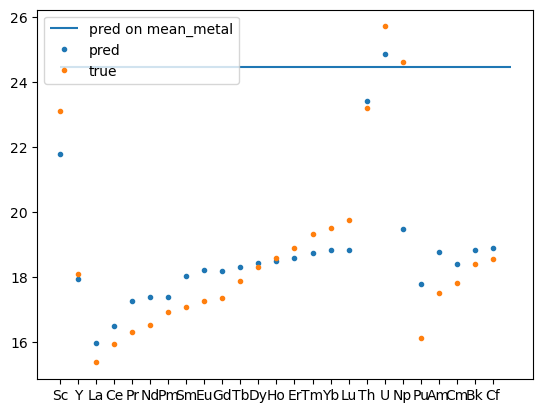

In [42]:
plt.hlines(mean_pred, 0, len(metals), label="pred on mean_metal")
plt.plot(ind, pred, ".", label="pred")
plt.plot(ind, true, ".", label="true")
plt.xticks(ind, metals)
plt.legend()
plt.show()

In [70]:
predict("CC(=O)", "mean")

1.2595487833023071

In [71]:
predict("CC(=O)", "zero")

1.4627457857131958

In [8]:
def get_props(mol):
    target = [p for p in mol.GetPropNames() if p.startswith(f"logK_")][0]
    element_symbol, charge_str, temperature_str, ionic_str_str = target.split("_")[1:]
    charge = float(charge_str.split("=")[-1])
    temperature = float(temperature_str.split("=")[-1])
    ionic_str = float(ionic_str_str.split("=")[-1])
    logK = float(mol.GetProp(target))
    return {"logK": logK, "z": charge, "T": temperature, "I": ionic_str}

datasets = {
    metal: {
        Chem.MolToSmiles(mol): get_props(mol)
        for mol in Chem.SDMolSupplier(str(ROOT_DIR / f"Data/OneM_cond_adds/{metal}.sdf"))
        if mol is not None
    } for metal in metals
}

def get_logK(smiles, metal):
    canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
    try:
        return datasets[metal][canonical_smiles]["logK"]
    except KeyError:
        return None

[11:39:38] Warning: molecule is tagged as 3D, but all Z coords are zero
[11:39:38] Warning: molecule is tagged as 3D, but all Z coords are zero
[11:39:38] Warning: molecule is tagged as 3D, but all Z coords are zero
[11:39:38] Warning: molecule is tagged as 3D, but all Z coords are zero
[11:39:39] Warning: molecule is tagged as 3D, but all Z coords are zero
[11:39:39] Warning: molecule is tagged as 3D, but all Z coords are zero
[11:39:39] Warning: molecule is tagged as 3D, but all Z coords are zero
[11:39:39] Warning: molecule is tagged as 3D, but all Z coords are zero
[11:39:39] Warning: molecule is tagged as 3D, but all Z coords are zero


In [69]:
metal = "Pr"
smiles = "NCC(=O)O"

datasets[metal][smiles]

{'logK': 3.3, 'z': 3.0, 'T': 25.0, 'I': 0.1}